# S-N-VAE Model Testing Framework

In [1]:
import sys
from pathlib import Path

# Find project root by looking for .git or requirements.txt
current = Path.cwd()
while not any((current / marker).exists() for marker in ['.git', 'requirements.txt']):
    if current.parent == current:
        raise FileNotFoundError("Project root not found")
    current = current.parent

sys.path.append(str(current))
print(f"Added project root: {current}")

Added project root: /notebooks


# Hyperparameters

In [2]:
import torch

#### deterministic run ####
determinism_kwargs = {
    'seed':2,
    'use_cuda_det': True,
    'enforce_det':False,
    'cublas_workspace_config': None,
}

##### Model parameters #####
model_name = 's_n_vae_locatello'  # S-N-VAE model with Locatello architecture
model_decoder_output_dist = 'bernoulli'  # Output distribution of the decoder

# Define latent factor topologies: mix of Normal (R1) and Power Spherical (S1)
latent_factor_topologies = ['S1', 'R1', 'R1']  # 3 factors total

use_torch_compile = True  # Use torch.compile for model compilation

#### Training parameters ####
train_step_unit = 'epoch'  # Unit for training steps ('epoch' or 'iteration')
num_train_steps = 300

# train_step_unit = 'iteration'  # Unit for training steps ('epoch' or 'iteration')
# num_train_steps = int(9e3)  # Number of training steps 

learning_rate = 1e-4
batch_size = 64

#### device parameters ####
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f"Using GPU")
else:
    print("Using CPU")

#### Group Theory Loss Configuration ####
loss_name = 'group_theory_snvae'  # Use S-N-VAE variant of group theory loss
loss_kwargs_dsprites = {
    # Base loss configuration
    'base_loss_name': 'beta_s_n_vae',
    'base_loss_kwargs': {
        'beta': 12,
        'latent_factor_topologies': latent_factor_topologies,
        'rec_dist': 'gaussian',  # Reconstruction distribution for the base loss
        'log_kl_components': True,
    },
    'rec_dist': 'gaussian',  # Reconstruction distribution for the base loss
    'device': device,  # Required for group theory loss
    
    # Group theory specific parameters
    'latent_factor_topologies': latent_factor_topologies,
    
    # Commutative loss parameters
    'commutative_weight': 0,
    'commutative_component_order': 2,
    'commutative_comparison_dist': 'gaussian',
    
    # Meaningful loss parameters  
    'meaningful_weight': 1.0,
    'meaningful_component_order': 2,
    'meaningful_transformation_order': 2,
    'meaningful_critic_gradient_penalty_weight': 10.0,
    'meaningful_critic_lr': 1e-4,
    'meaningful_n_critic': 5,
    
    # Group action parameters for mixed R1/S1 topology
    'g_action_r1_range': 2.0,
    'g_action_s1_range': 2 * torch.pi,
    'g_action_r1_dist': 'uniform',
    'g_action_s1_dist': 'uniform',
    
    # Other parameters
    'deterministic_rep': True,
    'comp_latent_select_threshold': 0,
    'warm_up_steps': 0,
}

### Checkpoint parameters ###
return_chkpt = False
chkpt_every_n_steps = 2400

# chkpt_save_path = 'checkpoints/tests/test-epoch-1.pt'
chkpt_save_path = None

chkpt_save_dir = None
# chkpt_save_dir = 'checkpoints/tests_s_n_vae'

chkpt_save_master_dir = None
chkpt_viz = False

Using GPU


## Group Theory S-N-VAE Loss Configuration

This notebook uses the **GroupTheorySNVAELoss** for S-N-VAE with mixed R¹ and S¹ topologies.

**Key Features:**
- **Loss Type**: `group_theory_snvae` - Specialized for mixed R¹/S¹ topology VAE models
- **Base Loss**: Beta S-N-VAE loss (β=12) with mixed topology support
- **Commutative Loss**: Enforces group commutativity properties (weight=1.0)
- **Meaningful Loss**: Uses adversarial critic to learn meaningful transformations (weight=1.0)
- **Mixed Topology**: Supports both R¹ (translation) and S¹ (rotation) factors
- **Group Actions**: 
  - R¹ factors: uniform sampling in range [-2, 2]
  - S¹ factors: uniform sampling in range [0, 2π]

The loss function enforces that:
1. **Commutativity**: g₁ ∘ g₂ = g₂ ∘ g₁ for group transformations
2. **Meaningful transformations**: Learned group actions correspond to meaningful semantic changes

**Note**: This uses the refactored `GroupTheorySNVAELoss` class which provides better naming and separation from the N-VAE variant (`GroupTheoryNVAELoss`).

# Reproducibility

In [3]:
if determinism_kwargs is not None:
    # MUST Be set before importing any other modules
    # to ensure reproducibility across all libraries
    from utils.reproducibility import set_deterministic_run, get_deterministic_dataloader
    set_deterministic_run(**determinism_kwargs)
    print(f"Set deterministic run with kwargs: {determinism_kwargs}")

Set deterministic run with kwargs: {'seed': 2, 'use_cuda_det': True, 'enforce_det': False, 'cublas_workspace_config': None}


# Imports

In [4]:
import torch
import numpy as np
import torch.utils
import matplotlib.pyplot as plt
import torch.optim as optim

import utils.visualize
from trainers import UnsupervisedTrainer
import losses
import vae_models
from datasets import get_dataset
from utils.io import find_optimal_num_workers
from metrics.utils import MetricAggregator

## Setup Model, Loss, and Optimizer

In [5]:
def setup_components(dataset, loss_kwargs, latent_factor_topologies):
    """Instantiates model, loss function, and optimizer based on config.
    
    Supports both standard losses (beta_s_n_vae) and group theory losses
    with mixed R¹/S¹ topology for disentanglement learning.
    """
    img_size = dataset[0][0].shape
    n_data = len(dataset)
    
    # Instantiate S-N-VAE Model
    model = vae_models.select(name=model_name, 
                              img_size=img_size, 
                              latent_factor_topologies=latent_factor_topologies,
                              decoder_output_dist=model_decoder_output_dist
                              ).to(device)

    # Instantiate Loss Function (supports group theory loss)
    loss_fn = losses.select(loss_name, **loss_kwargs)

    # Instantiate Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"--- Setup for {dataset.__class__.__name__} --- ")
    print(f"Model: {model.model_name}")
    print(f"Latent factor topologies: {latent_factor_topologies}")
    print(f"Loss: {loss_fn.name} (rec_dist={loss_kwargs['rec_dist']})")
    if hasattr(loss_fn, 'base_loss_name'):
        print(f"  - Base loss: {loss_fn.base_loss_name}")
        print(f"  - Commutative weight: {loss_kwargs.get('commutative_weight', 'N/A')}")
        print(f"  - Meaningful weight: {loss_kwargs.get('meaningful_weight', 'N/A')}")
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print(f"Learning rate: {learning_rate}")

    return model, loss_fn, optimizer

# dSprites

In [6]:
# Load dSprites
Dsprites = get_dataset('dsprites')

# dsprites_dataset = Dsprites(selected_factors='all', not_selected_factors_index_value=None)
dsprites_dataset = Dsprites(selected_factors=['posX', 'posY', 'orientation'], not_selected_factors_index_value={'scale':5, 'shape':0, 'color':0})

# num_workers_dsprites = find_optimal_num_workers(dsprites_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_dsprites = 7

if determinism_kwargs is not None:
    dsprites_dataloader = get_deterministic_dataloader(dataset=dsprites_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_dsprites,
                                                   seed=determinism_kwargs['seed'],
                                                   pin_memory=True)
else:
    dsprites_dataloader = torch.utils.data.DataLoader(dsprites_dataset, 
                                                      batch_size=batch_size, 
                                                      num_workers=num_workers_dsprites, 
                                                      shuffle=True, 
                                                      pin_memory=True)

print(f"Loaded dSprites dataset with {len(dsprites_dataset)} samples.")

Loaded dSprites dataset with 40960 samples.


## Train

In [7]:
print("\n===== Training S-N-VAE on dSprites =====")
model_dsprites, loss_fn_dsprites, optimizer_dsprites = setup_components(dsprites_dataset, 
                                                                        loss_kwargs_dsprites,
                                                                        latent_factor_topologies
                                                                        )
trainer_dsprites = UnsupervisedTrainer(model=model_dsprites,
                                      loss=loss_fn_dsprites,
                                      optimizer=optimizer_dsprites,
                                      lr_scheduler=None,
                                      determinism_kwargs=determinism_kwargs,
                                      use_torch_compile=use_torch_compile,
                                      return_logs=True,
                                      return_chkpt=return_chkpt,
                                      chkpt_save_path=chkpt_save_path,
                                      chkpt_save_dir=chkpt_save_dir,
                                      chkpt_every_n_steps=chkpt_every_n_steps,
                                      chkpt_viz=chkpt_viz
                                      )

trainer_dsprites.train(max_steps=num_train_steps, step_unit=train_step_unit, dataloader=dsprites_dataloader)


===== Training S-N-VAE on dSprites =====
--- Setup for DSprites --- 
Model: s_n_vae_locatello
Latent factor topologies: ['S1', 'R1', 'R1']
Loss: group_theory_s_n_vae (rec_dist=gaussian)
  - Base loss: beta_s_n_vae
  - Commutative weight: 0
  - Meaningful weight: 1.0
Optimizer: Adam
Learning rate: 0.0001


Training for 192000 iter, 300.00 epochs:   0%|          | 0/192000 [00:03<?, ?it/s]


IndexError: The shape of the mask [64, 1] at index 1 does not match the shape of the indexed tensor [64, 3, 1] at index 1

In [ ]:
print("\n===== Visualizing dSprites Results =====")
visualizer_dsprites = utils.visualize.SNVAEVisualizer(vae_model=model_dsprites, dataset=dsprites_dataset)


===== Visualizing dSprites Results =====


## Visualization

### Reconstructions

Plotting random reconstructions...


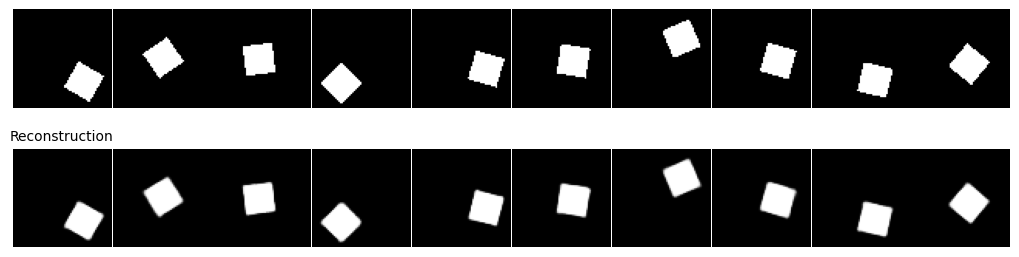

Plotting reconstructions from specific indices...


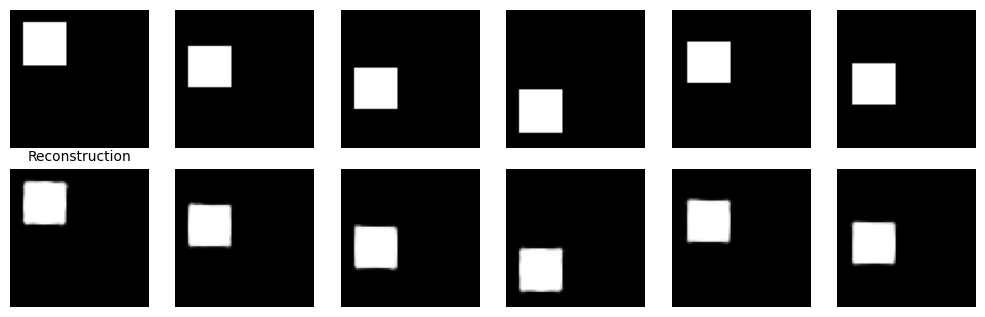

In [9]:
print("Plotting random reconstructions...")
visualizer_dsprites.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_dsprites = [0, 10, 20, 30, 40, 50]  # Example indices
visualizer_dsprites.plot_reconstructions_sub_dataset(indices_dsprites, mode='mean')
plt.show()

### Latent traversal

Plotting latent traversals...


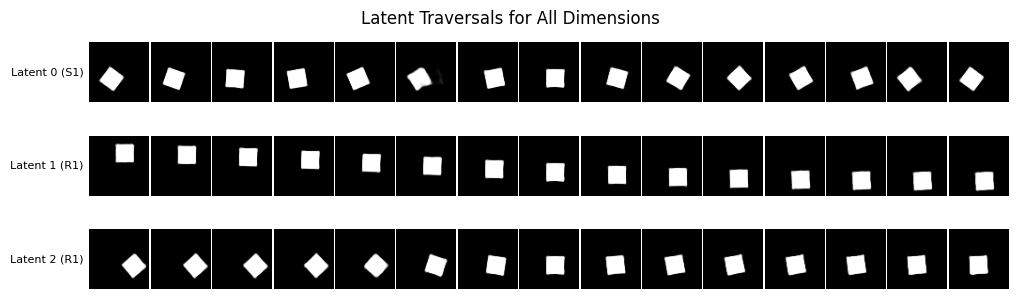

In [10]:
print("Plotting latent traversals...")
visualizer_dsprites.plot_all_latent_traversals(num_samples=15,
                                               r1_max_traversal_type='probability',
                                               r1_max_traversal=0.95,
                                               s1_max_traversal_type='fraction',
                                               s1_max_traversal=1.0,
                                               use_ref_img=True
                                               )
plt.show()

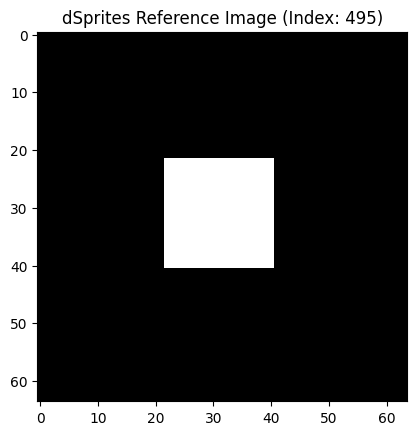

In [11]:
# Select a reference image index for dSprites
ref_img_idx_dsprites = 495  # Example index
ref_img_dsprites = dsprites_dataset[ref_img_idx_dsprites][0]

# Plot the reference image
plt.imshow(ref_img_dsprites.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title(f"dSprites Reference Image (Index: {ref_img_idx_dsprites})")
plt.show()

Plotting single latent traversal for dimension 0...


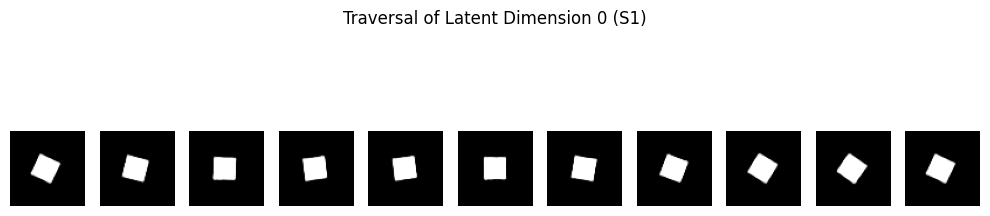

In [12]:
# Single latent traversal based on the reference image
latent_factor_idx_dsprites = 0  # Index of the latent dimension to traverse
print(f"Plotting single latent traversal for dimension {latent_factor_idx_dsprites}...")
visualizer_dsprites.plot_single_latent_traversal(latent_factor_idx_dsprites, 
                                                 ref_img=ref_img_dsprites, 
                                                 num_samples=11,
                                                 max_traversal_type='fraction',
                                                 max_traversal=1)
plt.show()

Plotting all latent traversals based on reference image...


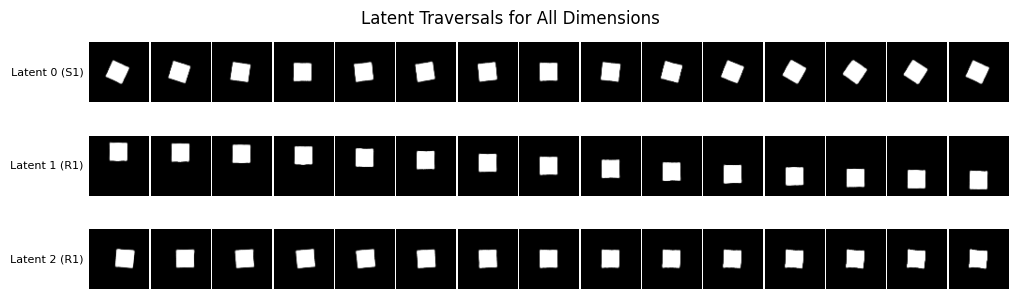

In [13]:
# All latent traversals based on the reference image
print("Plotting all latent traversals based on reference image...")
visualizer_dsprites.plot_all_latent_traversals(ref_img=ref_img_dsprites, 
                                               num_samples=15,
                                               r1_max_traversal_type='probability',
                                               r1_max_traversal=0.95,
                                               s1_max_traversal_type='fraction',
                                               s1_max_traversal=1
                                               )

## Metric Evaluation (dSprites)

In [ ]:
# print("\n===== Computing Metrics for dSprites =====")
# metric_aggregator_dsprites = MetricAggregator(metrics=metrics_to_compute)

# metrics_results_dsprites = metric_aggregator_dsprites.compute(model=model_dsprites, 
#                                                             data_loader=dsprites_dataloader, 
#                                                             device=device)
# print("dSprites Metrics:", metrics_results_dsprites)